In [41]:
import tensorflow as tf
import pickle
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import random

In [42]:
pickle_in = open("/home/karol/model_training_data/X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("/home/karol/model_training_data/y.pickle","rb")
y = pickle.load(pickle_in)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [44]:
X_train = X_train/255.
X_test = X_test/255.

In [45]:
X_test.dtype, X_train.dtype

(dtype('float64'), dtype('float64'))

In [46]:
print(y_train.shape)

(7200, 1)


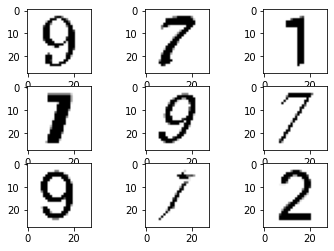

In [47]:
plt.figure()
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

In [48]:
IMG_SHAPE = X_train.shape[1:]

In [49]:
model = models.Sequential()
model.add(layers.Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=IMG_SHAPE))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(9, activation='softmax'))

In [50]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 flatten_2 (Flatten)         (None, 9216)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               1179776   
                                                      

In [60]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = model.fit(X_train, y_train, epochs=35,
                    verbose = 1,
                    batch_size=128,
                    validation_data=(X_test,y_test))

Epoch 1/35


/home/karol/.local/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


57/57 [==============================] - 4s 57ms/step - loss: 0.0056 - accuracy: 0.9985 - val_loss: 0.0111 - val_accuracy: 0.9972
Epoch 2/35
57/57 [==============================] - 3s 56ms/step - loss: 0.0075 - accuracy: 0.9976 - val_loss: 0.0055 - val_accuracy: 0.9983
Epoch 3/35
57/57 [==============================] - 3s 56ms/step - loss: 0.0095 - accuracy: 0.9965 - val_loss: 0.0087 - val_accuracy: 0.9961
Epoch 4/35
57/57 [==============================] - 3s 55ms/step - loss: 0.0167 - accuracy: 0.9956 - val_loss: 0.0174 - val_accuracy: 0.9928
Epoch 5/35
57/57 [==============================] - 3s 56ms/step - loss: 0.0102 - accuracy: 0.9974 - val_loss: 0.0057 - val_accuracy: 0.9978
Epoch 6/35
57/57 [==============================] - 3s 56ms/step - loss: 0.0064 - accuracy: 0.9982 - val_loss: 0.0080 - val_accuracy: 0.9967
Epoch 7/35
57/57 [==============================] - 3s 56ms/step - loss: 0.0049 - accuracy: 0.9987 - val_loss: 0.0050 - val_accuracy: 0.9983
Epoch 8/35
57/57 [======

KeyboardInterrupt: 

Text(0.5, 0, 'epochs')

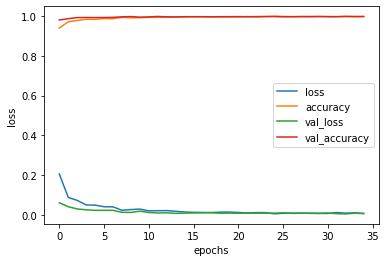

In [57]:
pd.DataFrame(history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs")

In [58]:
model.evaluate(X_test, y_test)

57/57 [==============================] - 0s 4ms/step - loss: 0.0075 - accuracy: 0.9972


[0.007475823163986206, 0.9972222447395325]

In [59]:
model.save("model.h5")